# Report from lab8
## Grzegorz Biały



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')

In [2]:
ans = pd.read_csv('http://bioinformatics.netmark.pl/teaching/dav_20/labs/lab8/ans.csv')
ans2 = pd.read_csv('http://bioinformatics.netmark.pl/teaching/dav_20/labs/lab8/ans2.tsv', sep='\t')

In [3]:
def variance_interval(data,alpha=0.95):
    var_est = np.var(data)
    n = data.size
    c_1 = scipy.stats.chi2.ppf(alpha/2, n-1)
    c_2 = scipy.stats.chi2.ppf(1 - (alpha/2), n-1)
    v_1 = ((n-1) * var_est)/c_2
    v_2 = ((n-1) * var_est)/c_1
    return((round(v_1,3),round(v_2,3)))

def mean_interval(data,alpha=0.95):
    var_est = np.var(data)
    mean_est = np.mean(data)
    n = data.size
    t= scipy.stats.t.ppf(1 - (alpha/2),n-1)
    m_1 = mean_est - (var_est**(0.5)) * t / n**(0.5) 
    m_2 = mean_est + (var_est**(0.5)) * t / n**(0.5) 
    return((round(m_1,3),round(m_2,3)))

def correlation_interval(data, alpha = 0.95):
    correlation = np.corrcoef(data)[0,1]
    n = data.shape[1]
    z = math.log((1 + correlation) / (1 - correlation)) / 2.0
    se = 1.0 / math.sqrt(n - 3)
    z_crit = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    z_1 = z - z_crit * se
    z_2 = z + z_crit * se
    
    e_1 = math.exp(2 * z_1)
    e_2 = math.exp(2 * z_2)

    return((round((e_1 - 1) / (e_1 + 1),3),round((e_2 - 1) / (e_2 + 1),3)))

def coefficient_interval(x,y,alpha = 0.95):
    X = sm.tools.tools.add_constant(x)
    mod = sm.OLS(y, X)
    res = mod.fit()
    b_1 = round(res.conf_int(alpha).iloc[1][0],3)
    b_2 = round(res.conf_int(alpha).iloc[1][0],3)
    return((b_1,b_2))

def intercept_interval(x,y,alpha = 0.95):
    X = sm.tools.tools.add_constant(x)
    mod = sm.OLS(y, X)
    res = mod.fit()
    b_1 = round(res.conf_int(alpha).iloc[0][0],3)
    b_2 = round(res.conf_int(alpha).iloc[0][0],3)
    return((b_1,b_2))

In [4]:
tables = []
for i in range(1,5):
    x_i = 'x' + str(i)
    y_i = 'y' + str(i)
    table_i = pd.DataFrame(columns = ['property','value','accuracy'])
    # mean of x:
    dict_temp = {
        'property': ['Mean of x'],
        'value': [str(round(np.mean(ans[x_i]),3))],
        'accuracy' : [str(mean_interval(ans[x_i]))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp), ignore_index=True)
    
    # sample variance of x:
    dict_temp = {
        'property': ['Sample variance of x'],
        'value': [str(round(np.mean(ans[x_i]),3))],
        'accuracy' : [str(variance_interval(ans[x_i]))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # mean of y:
    dict_temp = {
        'property': ['Mean of x'],
        'value': [str(round(np.mean(ans[y_i]),3))],
        'accuracy' : [str(mean_interval(ans[y_i]))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # sample variance of y:
    dict_temp = {
        'property': ['Sample variance of y'],
        'value': [str(round(np.mean(ans[y_i]),3))],
        'accuracy' : [str(variance_interval(ans[y_i]))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # correlation between x and y
    dict_temp = {
        'property': ['correlation between x and y'],
        'value': [str(round(np.corrcoef(np.array([ans[x_i],ans[y_i]]))[0,1],3))],
        'accuracy' : [str(correlation_interval(np.array([ans[x_i],ans[y_i]])))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # linear regression
    x = np.transpose(np.array([ans[x_i]]))
    y = np.transpose(np.array([ans[y_i]]))
    reg = LinearRegression().fit(x, y)
    
    dict_temp = {
        'property': ['linear regression'],
        'value': ['a = ' + str(round(reg.coef_[0,0],3)) + ', b= ' + str(round(reg.intercept_[0],3))],
        'accuracy' : ['a: '+ str(coefficient_interval(ans[x_i],ans[y_i])) + ' b: ' + str(intercept_interval(ans[x_i],ans[y_i]))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # Coefficient of determination of the linear regression
    y_pred = reg.coef_[0] * ans[x_i] + np.full(shape = ans[y_i].shape, fill_value = reg.intercept_)
                                
    dict_temp = {
        'property': ['Coefficient of determination of the linear regression'],
        'value': [str(round(r2_score(ans[y_i],y_pred),3))],
        'accuracy' : ['?']
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))                            
                                 
    tables.append(table_i)

In [5]:
tables_2 = []
for set_name in list(set(ans2['dataset'])):
    table_temp = ans2.loc[ans2['dataset'] == set_name]
    x_i = 'x' + str(i)
    y_i = 'y' + str(i)
    table_i = pd.DataFrame(columns = ['property','value','accuracy'])
    # mean of x:
    dict_temp = {
        'property': ['Mean of x'],
        'value': [str(round(np.mean(table_temp['x']),3))],
        'accuracy' : [str(mean_interval(table_temp['x']))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp), ignore_index=True)
    
    # sample variance of x:
    dict_temp = {
        'property': ['Sample variance of x'],
        'value': [str(round(np.mean(table_temp['x']),3))],
        'accuracy' : [str(variance_interval(table_temp['x']))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # mean of y:
    dict_temp = {
        'property': ['Mean of x'],
        'value': [str(round(np.mean(table_temp['y']),3))],
        'accuracy' : [str(mean_interval(table_temp['y']))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # sample variance of y:
    dict_temp = {
        'property': ['Sample variance of y'],
        'value': [str(round(np.mean(table_temp['y']),3))],
        'accuracy' : [str(variance_interval(table_temp['y']))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # correlation between x and y
    dict_temp = {
        'property': ['correlation between x and y'],
        'value': [str(round(np.corrcoef(np.array([table_temp['x'],table_temp['y']]))[0,1],3))],
        'accuracy' : [str(correlation_interval(np.array([table_temp['x'],table_temp['y']])))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # linear regression
    x = np.transpose(np.array([table_temp['x']]))
    y = np.transpose(np.array([table_temp['y']]))
    reg = LinearRegression().fit(x, y)
    
    dict_temp = {
        'property': ['linear regression'],
        'value': ['a = ' + str(round(reg.coef_[0,0],3)) + ', b= ' + str(round(reg.intercept_[0],3))],
        'accuracy' : ['a: '+ str(coefficient_interval(table_temp['x'],table_temp['y'])) + ' b: ' + str(intercept_interval(table_temp['x'],table_temp['y']))]
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))
    
    # Coefficient of determination of the linear regression
    y_pred = reg.coef_[0] * table_temp['x'] + np.full(shape = table_temp['y'].shape, fill_value = reg.intercept_)
                                
    dict_temp = {
        'property': ['Coefficient of determination of the linear regression'],
        'value': [str(round(r2_score(table_temp['y'],y_pred),3))],
        'accuracy' : ['?']
    }
    table_i = table_i.append(pd.DataFrame.from_dict(dict_temp))                            
                                 
    tables_2.append(table_i)

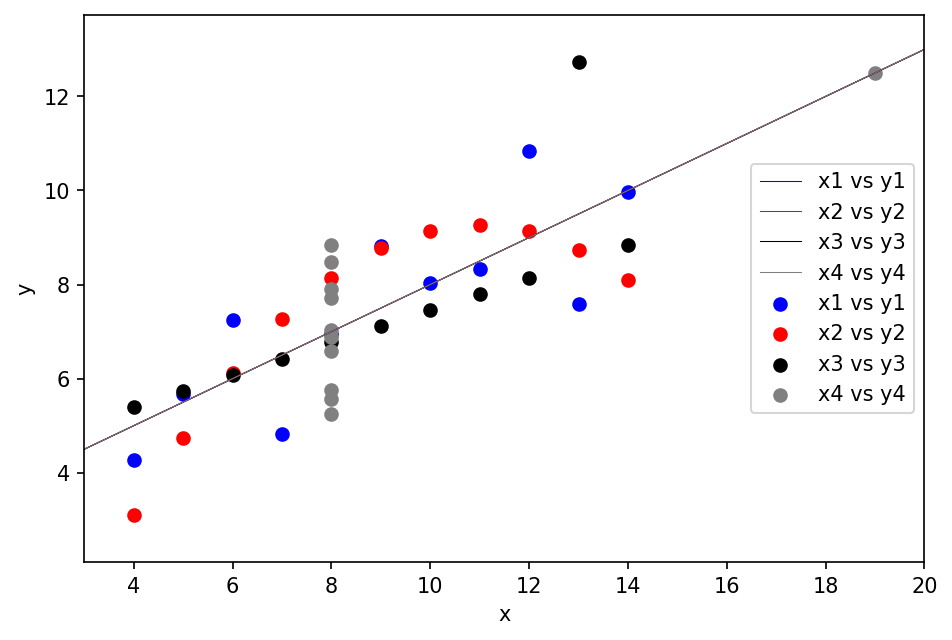

In [6]:
all_x = []
all_y = []

for i in range(1,5,1):
    all_x = all_x + list(ans['x'+str(i)])
    all_y = all_y + list(ans['y'+str(i)])
    
min_x = min(all_x)
max_x = max(all_x)

min_y = min(all_y)
max_y = max(all_y)

colors = ['blue','red','black','gray']

fig, ax = plt.subplots(figsize = [8,5], dpi = 150)

for i in range(1,5,1):
    x_temp = ans['x'+str(i)]
    y_temp =ans['y'+str(i)]
    x = np.transpose(np.array([x_temp]))
    y = np.transpose(np.array([y_temp]))
    reg = LinearRegression().fit(x, y)
    a_temp = reg.coef_[0,0]
    b_temp = reg.intercept_[0]
    x_line = [min_x-1,max_x+1]
    y_line = list(a_temp * np.array(x_line) + np.full(shape = np.array(x_line).shape, fill_value = b_temp))
    
    ax.scatter(x_temp,y_temp,color = colors[i-1], label = 'x'+str(i) + ' vs ' + 'y'+str(i))              
    ax.plot(x_line,y_line, linestyle = '-',color =  colors[i-1], linewidth = 0.5, label = 'x'+str(i) + ' vs ' + 'y'+str(i))
    

ax.set_xlabel('x')
ax.set_ylabel('y')    
ax.set_xlim(min_x-1,max_x+1)
ax.set_ylim(min_y - 1,max_y + 1)   

fig.subplots_adjust(bottom=0.15, left = 0.1, right = 0.8)
ax.legend(loc='center right')

plt.show()   


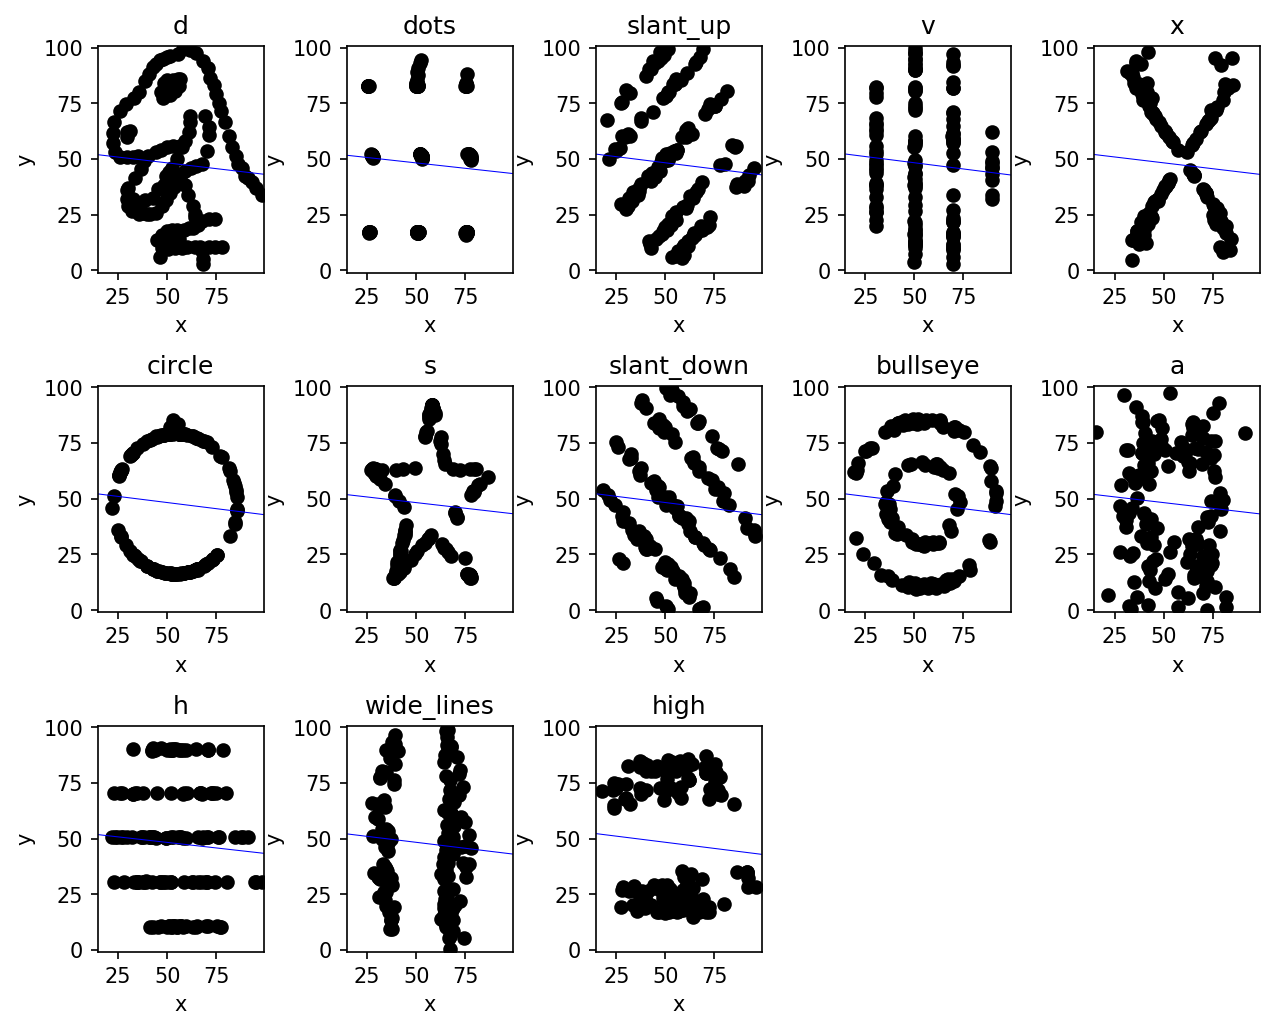

In [7]:

min_x = min(list(ans2['x']))
max_x = max(list(ans2['x']))

min_y = min(list(ans2['y']))
max_y = max(list(ans2['y']))

fig, axs = plt.subplots(3, 5,figsize = [10,8], dpi = 150)

row = 0
column = 0

for set_name in list(set(ans2['dataset'])):
    table_temp = ans2.loc[ans2['dataset'] == set_name]
    x_temp = table_temp['x']
    y_temp = table_temp['y']
    x = np.transpose(np.array([x_temp]))
    y = np.transpose(np.array([y_temp]))
    reg = LinearRegression().fit(x, y)
    a_temp = reg.coef_[0,0]
    b_temp = reg.intercept_[0]
    x_line = [min_x-1,max_x+1]
    y_line = list(a_temp * np.array(x_line) + np.full(shape = np.array(x_line).shape, fill_value = b_temp))
    
    axs[row,column].set_xlabel('x')
    axs[row,column].set_ylabel('y')
    axs[row,column].set_title(set_name)
    axs[row,column].scatter(x_temp,y_temp,color = 'k')              
    axs[row,column].plot(x_line,y_line, linestyle = '-', color = 'b', linewidth = 0.5)
    axs[row,column].set_xlim(min_x-1,max_x+1)
    axs[row,column].set_ylim(min_y - 1,max_y + 1)
  
    column = column + 1
    
    if(column == 5):
        column = 0
        row = row + 1

axs[2,3].axis('off')
axs[2,4].axis('off')
plt.subplots_adjust(hspace=0.5, wspace = 0.5)

plt.show()   
